In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout, Activation
from tensorflow.keras.losses import Huber, mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

Using LSTM

In [4]:
data=yfinance.download('MGLU3.SA', start='2018-01-01', end=datetime.datetime.today())

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2.528125,2.574375,2.450312,2.478125,2.392650,59427200
2018-01-03,2.468750,2.542500,2.422500,2.446875,2.362478,41385600
2018-01-04,2.500000,2.516250,2.478125,2.505625,2.419202,47936000
2018-01-05,2.514062,2.528437,2.448437,2.456250,2.371529,30684800
2018-01-08,2.453125,2.503437,2.448437,2.456562,2.371830,28796800


In [6]:
scaler=MinMaxScaler()
data_scaler=scaler.fit_transform(data[['Open','High','Low','Close','Volume']])
data_scaler=pd.DataFrame(data_scaler, columns=['Open','High','Low','Close','Volume'])
data_scaler

,Open,High,Low,Close,Volume
0,0.007145,0.006514,0.007774,0.006725,0.164489
1,0.004844,0.005284,0.006638,0.005482,0.114552
2,0.006055,0.004271,0.008910,0.007818,0.132683
3,0.006600,0.004741,0.007698,0.005855,0.084933
4,0.004238,0.003776,0.007698,0.005867,0.079707
...,...,...,...,...,...
827,0.668685,0.669168,0.682598,0.669861,0.074818
828,0.650085,0.649094,0.672794,0.658326,0.043626
829,0.638847,0.656429,0.674428,0.662701,0.050141
830,0.636135,0.645234,0.665033,0.651167,0.046713


In [7]:
X=data_scaler.drop('Close',axis=1)
y=data_scaler['Close']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=False)

In [9]:
#Setting Window_size
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
WINDOW_SIZE=30
BATCH_SIZE=32

In [11]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [24]:
model=Sequential()
model.add(LSTM(50, input_shape=(WINDOW_SIZE,1), return_sequences=True))
model.add(LSTM(30, input_shape=(50,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 20,151
Trainable params: 20,151
Non-trainable params: 0
_________________________________________________________________


In [25]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [26]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50,
                    batch_size=2,
                    verbose=2,
                
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
20/20 - 4s - loss: 0.0264 - val_loss: 0.0367

Epoch 00001: val_loss improved from inf to 0.03671, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
20/20 - 1s - loss: 0.0037 - val_loss: 0.0130

Epoch 00002: val_loss improved from 0.03671 to 0.01298, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
20/20 - 1s - loss: 0.0012 - val_loss: 0.0087

Epoch 00003: val_loss improved from 0.01298 to 0.00873, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
20/20 - 1s - loss: 9.6594e-04 - val_loss: 0.0040

Epoch 00004: val_loss improved from 0.00873 to 0.00401, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
20/20 - 1s - loss: 8.8887e-04 - val_loss: 0.0042

Epoch 00005: val_loss did not improve from 0.00401
Epoch 6/50
20/20 - 1s - loss: 8.6058e-04 - val_loss: 0.0039

Epoch 00006: val_loss improved from 0.00401 to 0.00386, saving model to tmp/ckeckpointer.ckpt
Epoch 7/50
20/20 - 1s - loss: 8.3764e-04 - val_loss: 0.0027

Epoch 00007: val_loss improved from 0.00386 to 0.00266, saving model

In [27]:
pred = model.predict(test_data)

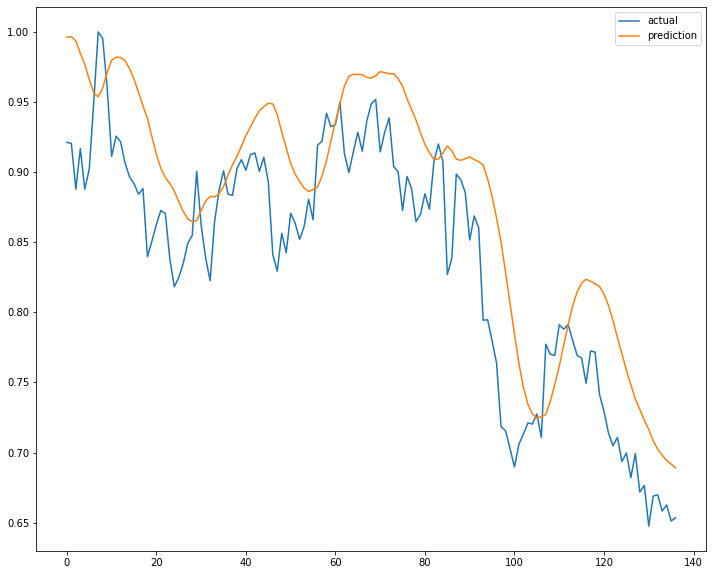

In [28]:
plt.figure(figsize=(12, 10))
plt.plot(np.asarray(y_test)[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [78]:
test=predict_model(final_gbr, data_pycaret)

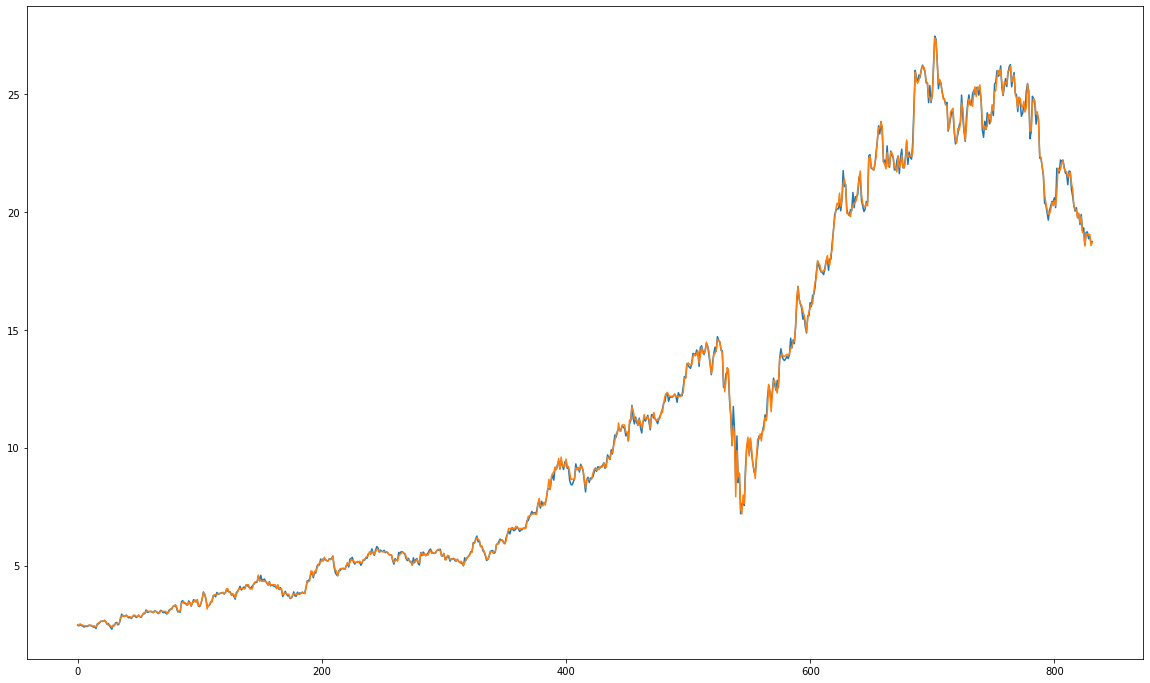

In [83]:
plt.figure(figsize=(20,12))

plt.plot(test['Close'])
plt.plot(test['Label'])

USING Pycaret

In [90]:
data_pycaret=yfinance.download('MGLU3.SA', start='2018-01-01', end=datetime.datetime.today())

[*********************100%***********************]  1 of 1 completed


In [91]:
data_pycaret=data_pycaret.reset_index(drop=True)

In [92]:
from pycaret.regression import *

In [93]:
data = data_pycaret.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = data_pycaret.drop(data.index).reset_index(drop=True)

In [94]:
data

,Open,High,Low,Close,Adj Close,Volume
0,5.331562,5.481250,5.212500,5.212500,5.063164,37664000
1,5.656250,5.755937,5.562500,5.632812,5.483852,35641600
2,2.462500,2.556250,2.442187,2.551250,2.463253,44371200
3,3.893750,4.098437,3.892500,4.075000,3.945295,55385600
4,19.822500,20.250000,19.737499,20.045000,19.908152,51957600
...,...,...,...,...,...,...
619,10.550000,10.795000,10.512500,10.667500,10.405344,42348000
620,12.372500,12.470000,12.165000,12.325000,12.022111,42746000
621,5.006250,5.140000,5.004687,5.073437,4.911953,38089600
622,9.575000,9.920000,9.570000,9.912500,9.668900,35893600


In [95]:
exp_reg101 = setup(data = data, target = 'Close', session_id=123, normalize=True, transformation=True) 

,Description,Value
0,session_id,123
1,Target,Close
2,Original Data,"(624, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(436, 1)"


In [96]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,6.6970,59.7185,7.7059,-0.0279,0.6850,0.9799,0.248
ridge,Ridge Regression,6.6969,59.7177,7.7058,-0.0279,0.6850,0.9799,0.014
lar,Least Angle Regression,6.6970,59.7185,7.7059,-0.0279,0.6850,0.9799,0.012
omp,Orthogonal Matching Pursuit,6.6970,59.7185,7.7059,-0.0279,0.6850,0.9799,0.013
br,Bayesian Ridge,6.6932,59.8266,7.7114,-0.0289,0.6855,0.9798,0.013
en,Elastic Net,6.6918,59.9562,7.7176,-0.0301,0.6858,0.9793,0.014
lasso,Lasso Regression,6.6917,60.0316,7.7220,-0.0312,0.6859,0.9789,0.014
llar,Lasso Least Angle Regression,6.6917,60.0316,7.7220,-0.0312,0.6859,0.9789,0.013
huber,Huber Regressor,6.5771,61.7306,7.8155,-0.0531,0.6620,0.8580,0.015
ada,AdaBoost Regressor,6.8720,62.0730,7.8686,-0.0773,0.7097,1.0585,0.024


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [97]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.7274,78.2513,8.8460,-0.0118,0.7306,1.0331
1,7.4122,72.2112,8.4977,-0.0012,0.6800,0.8900
2,6.4937,54.8416,7.4055,-0.0631,0.7080,1.0855
3,6.3675,51.6030,7.1835,-0.0598,0.6472,0.9134
4,6.8616,58.6974,7.6614,-0.0217,0.7176,1.0967
5,5.8711,51.1304,7.1506,0.0191,0.6562,0.9154
6,6.2884,50.8726,7.1325,-0.0868,0.7098,1.1132
7,7.0784,67.9110,8.2408,-0.0432,0.6611,0.8453
8,6.4016,53.3690,7.3054,0.0239,0.6531,0.9216
9,6.4679,58.2977,7.6353,-0.0349,0.6869,0.9852


In [58]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1443,0.0504,0.2245,0.9990,0.0153,0.0132
1,0.1587,0.0548,0.2340,0.9991,0.0179,0.0165
2,0.1801,0.0790,0.2811,0.9987,0.0279,0.0187
3,0.1199,0.0266,0.1631,0.9994,0.0138,0.0125
4,0.1266,0.0285,0.1688,0.9995,0.0126,0.0123
5,0.1907,0.0797,0.2824,0.9987,0.0186,0.0166
6,0.1483,0.0393,0.1983,0.9993,0.0134,0.0123
7,0.1797,0.0927,0.3045,0.9987,0.0171,0.0145
8,0.1849,0.1322,0.3636,0.9979,0.0320,0.0181
9,0.1551,0.0615,0.2479,0.9990,0.0159,0.0133


In [61]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1505,0.0478,0.2187,0.9991,0.0200,0.0182
1,0.1661,0.0602,0.2454,0.9990,0.0212,0.0189
2,0.1968,0.0903,0.3005,0.9986,0.0274,0.0186
3,0.1321,0.0395,0.1989,0.9991,0.0156,0.0132
4,0.1577,0.0438,0.2092,0.9993,0.0198,0.0181
5,0.2032,0.0967,0.3110,0.9984,0.0200,0.0188
6,0.1908,0.0833,0.2887,0.9985,0.0182,0.0166
7,0.2028,0.1071,0.3273,0.9985,0.0182,0.0161
8,0.1707,0.0986,0.3140,0.9984,0.0280,0.0174
9,0.1699,0.0614,0.2477,0.9990,0.0173,0.0156


In [59]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1590,0.0637,0.2524,0.9988,0.0197,0.0158
1,0.1847,0.0758,0.2753,0.9987,0.0217,0.0195
2,0.1778,0.0784,0.2800,0.9988,0.0284,0.0190
3,0.1309,0.0339,0.1840,0.9992,0.0166,0.0142
4,0.1455,0.0380,0.1949,0.9994,0.0160,0.0152
5,0.1950,0.0773,0.2780,0.9987,0.0178,0.0174
6,0.1626,0.0431,0.2077,0.9992,0.0161,0.0149
7,0.1747,0.0799,0.2826,0.9989,0.0213,0.0164
8,0.1701,0.0976,0.3124,0.9984,0.0280,0.0179
9,0.1646,0.0585,0.2418,0.9990,0.0170,0.0149


In [98]:
predict_model(lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.5351,56.216,7.4977,0.0057,0.6988,1.0417


In [63]:
predict_model(rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1713,0.0739,0.2719,0.9988,0.0202,0.0166


In [64]:
predict_model(lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1741,0.0743,0.2725,0.9987,0.0197,0.0167


In [65]:
predict_model(gbr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1593,0.0641,0.2533,0.9989,0.0185,0.0153


In [72]:
final_lgbm = finalize_model(lgbm)

In [73]:
final_lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [99]:
unseen_predictions = predict_model(final_lr, data=data_unseen)

In [100]:
unseen_predictions

,Open,High,Low,Close,Adj Close,Volume,Label
0,20.325001,20.475000,20.217501,20.375000,20.235899,51096800,12.60596
1,20.275000,20.450001,19.785000,20.045000,19.908152,44875200,12.60596
2,20.125000,20.555000,20.120001,20.500000,20.360044,44042000,12.60596
3,20.590000,21.790001,20.527500,21.750000,21.601511,43484800,12.60596
4,22.177500,22.375000,20.930000,21.075001,20.931120,61190000,12.60596
...,...,...,...,...,...,...,...
203,19.600000,19.740000,18.969999,19.150000,19.150000,27030400,12.60596
204,19.120001,19.219999,18.730000,18.860001,18.860001,15761200,12.60596
205,18.830000,19.410000,18.770000,18.969999,18.969999,18115000,12.60596
206,18.760000,19.120001,18.540001,18.680000,18.680000,16876700,12.60596


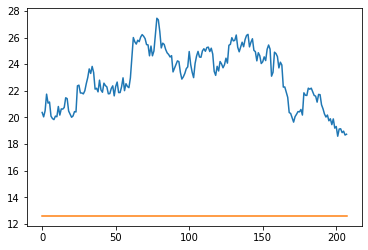

In [101]:
plt.plot(unseen_predictions['Close'])
plt.plot(unseen_predictions['Label'])

In [108]:
!pip install prophet

     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 184kB 12.7MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640005 sha256=9f9e4b4fae0b6181c05c72fd4a1080e92a94da2aa71d844e351e979ba8965c1c
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [121]:
data

,Open,High,Low,Close,Adj Close,Volume,y,ds
Date,,,,,,,,
2018-01-02,2.528125,2.574375,2.450312,2.478125,2.392650,59427200,2.478125,2018-01-02
2018-01-03,2.468750,2.542500,2.422500,2.446875,2.362478,41385600,2.446875,2018-01-03
2018-01-04,2.500000,2.516250,2.478125,2.505625,2.419202,47936000,2.505625,2018-01-04
2018-01-05,2.514062,2.528437,2.448437,2.456250,2.371529,30684800,2.456250,2018-01-05
2018-01-08,2.453125,2.503437,2.448437,2.456562,2.371830,28796800,2.456562,2018-01-08
...,...,...,...,...,...,...,...,...
2021-05-14,19.600000,19.740000,18.969999,19.150000,19.150000,27030400,19.150000,2021-05-14
2021-05-17,19.120001,19.219999,18.730000,18.860001,18.860001,15761200,18.860001,2021-05-17
2021-05-18,18.830000,19.410000,18.770000,18.969999,18.969999,18115000,18.969999,2021-05-18


In [116]:
from prophet.diagnostics import performance_metrics
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation


In [ ]:
!pip install fbprophet

In [126]:
data=yfinance.download('MGLU3.SA', start='2015-01-01', end=datetime.datetime.today())

[*********************100%***********************]  1 of 1 completed


In [127]:
data['y']=data['Close']
data['ds']=data.index

In [128]:
prophet=Prophet(daily_seasonality=True)
prophet.fit(data)
future=prophet.make_future_dataframe(periods=30)
forecast=prophet.predict(future)

In [129]:
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2017-06-05 00:00:00 and 2020-05-20 00:00:00


In [130]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-06-06,0.992209,0.952282,1.027316,0.925781,2017-06-05
1,2017-06-07,0.996398,0.957267,1.036697,0.974570,2017-06-05
2,2017-06-08,1.000203,0.960357,1.038699,1.004726,2017-06-05
3,2017-06-09,1.005717,0.968316,1.044128,0.984375,2017-06-05
4,2017-06-12,1.018244,0.981468,1.056741,0.969960,2017-06-05


In [132]:
df_p = performance_metrics(df_cv)

In [133]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,1.022808,1.011340,0.606041,0.078891,0.073448,0.081095,0.254335
1,38 days,1.022636,1.011255,0.606091,0.078427,0.073199,0.080750,0.249711
2,39 days,1.023233,1.011550,0.606157,0.078370,0.073464,0.080828,0.246243
3,40 days,1.086955,1.042571,0.626556,0.079013,0.073601,0.081753,0.242775
4,41 days,1.162696,1.078284,0.649196,0.078850,0.075098,0.081842,0.236994
...,...,...,...,...,...,...,...,...
324,361 days,18.103512,4.254822,3.003343,0.233275,0.293373,0.277486,0.173410
325,362 days,18.553998,4.307435,3.043476,0.231934,0.296929,0.275980,0.179191
326,363 days,18.365908,4.285546,3.036753,0.230335,0.293373,0.273761,0.179191
327,364 days,17.977548,4.239994,3.006372,0.231324,0.293373,0.275008,0.174566
